[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/dbwilburn/BIOC6765/blob/main/probability_simulations.ipynb)

### Python data science basics and likelihood calculations

***

DBW 2023-01-19

To make best use of this notebook, Edit > Clear all outputs, then run desired cells sequentially

The purpose of this notebook is simulate biophysical experiments and compare estimation approaches

Install the required packages; for docs for details

Numpy: https://numpy.org/doc/
<br>
Pandas: https://pandas.pydata.org/docs/
<br>
Scipy: https://docs.scipy.org/doc/scipy/
<br>
Matplotlib: https://matplotlib.org/stable/index.html
<br>

*If already installed, can comment out the next line, or just not run the cell*

In [1]:
!pip install numpy pandas scipy matplotlib

In [314]:
## Libraries

import numpy as np, pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit

import matplotlib.cm as cm



## Binding isotherm simulation

Simulate a binding curve for **Ligand** binding to **Receptor** via *your favorite method* with **K_d = 2.0 $\mu$ M**, **free signal = 0.1**, **saturated signal = 0.28**, and **$\sigma$ = 0.03**

In [95]:
## Define the variables
K_d = 2.0
free_signal = 0.1 # Y-intercept
saturated_signal = 0.28
delta_signal = saturated_signal - free_signal  # Slope relative to fractional saturation



In [189]:
## Define the simulation conditions
seed = 2984

# Three equations for binding (with quadratic being "true")
def quadratic_fit( X, K ):
    L, R = X
    return ( L + R + K - np.sqrt( ( L + R + K )**2 - 4*L*R ) ) / 2

def sigmoid_fit( L, K ):
    return L / ( L + K )

def hill_fit( L, K, n ):
    return np.power( L, n ) / ( np.power( L, n ) + np.power( K, n ) )


## Since quadratic fit is takes into account both L and R, it tends to be the best fit, so use it for simulations

receptor_conc = 2.0 # uM
concs = [ 0.0, 0.5, 1.0, 1.5, 2.0, 3.0, 4.0, 5.0, 7.0, 10.0, 15.0, 20.0 ] # uM
ligand_concs = np.array( concs * 3 ) # Treat in technical duplicate
theta_bound = quadratic_fit( [ligand_concs, receptor_conc,], K_d )
signal = delta_signal * theta_bound + free_signal + stats.norm.rvs( loc=0.0, scale=0.004, size=len(ligand_concs), random_state=seed, )

bi_df = pd.DataFrame( { 'Conc' : ligand_concs, 'Signal' : signal, } )

bi_df


,Conc,Signal
0,0.0,0.101830
1,0.5,0.134319
2,1.0,0.180698
3,1.5,0.213566
4,2.0,0.239128
5,3.0,0.272394
6,4.0,0.316193
7,5.0,0.333050
8,7.0,0.363379
9,10.0,0.390919


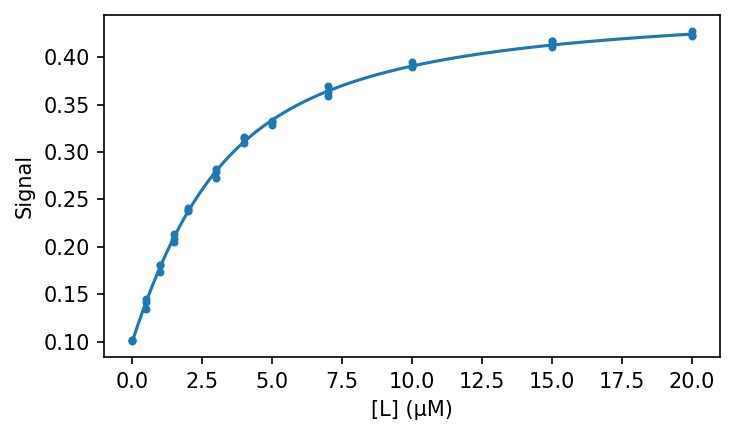

In [190]:
## Plot the simulated signal versus concentration, with expected quadratic line

fig, ax = plt.subplots( figsize=(5,3), dpi=150, )

ax.scatter( bi_df.Conc, bi_df.Signal, s=8, )

# Calculate the expected line
xt = np.linspace( 0, 20, 1000 )
yt = delta_signal * quadratic_fit( [xt, receptor_conc,], K_d, ) + free_signal
ax.plot( xt, yt, )

ax.set_xlabel( '[L] (μM)' )
ax.set_ylabel( 'Signal' )

fig.tight_layout()


Let's try to fit these data using each of our three possible models

We will perform fitting using the scipy package `curve_fit`, which optimizes the least squared residuals using the Levenberg-Marquardt algorithm. The main inputs of `curve_fit` are **f**, **x**, **y**, and **$\theta_{init}$**. The function **f** should take the form **f(x, \*$\theta$)** where **$\theta$ = estimatable parameters**. There are **three** or **four** variables that we need to estimate, depending on the model: instrument linear factors **m** and **b**, **$K_d$**, and if using the *Hill equation*, also **n**. Since non-linear estimators require initial input values from which to compute the gradients, we can try to provide some sensible estimates by drawing naive inferences from the data

In [191]:
## Estimate initial parameters

# Linear factors for scaling frac_bound to instrument response
# Assume min_value = 0 and max_value = 1
min_signal = np.min( bi_df.Signal ) # min signal
max_signal = np.max( bi_df.Signal ) # max signal
signal_range = max_signal - min_signal

# Estimate K_d by finding point closest to 50% of signal range
est_50p = min_signal + 0.5 * signal_range
Kd_est = bi_df.Conc[ np.argmin( np.abs( bi_df.Signal - est_50p ) ) ]

# For n, do a quick grid search from 1 to 3
# Based on current estimates, find the best value that minimizes the sum of squared residuals for the Hill equation
n_est = 0.0
best_ssr = 1e6
for n in np.arange( 1, 3.1, 0.1, ):
    s_fit = hill_fit( bi_df.Conc, Kd_est, n )
    residuals = bi_df.Signal - s_fit
    ssr = np.sum( np.square( residuals ) )
    if ssr < best_ssr:
        n_est = n
        best_ssr = ssr


# Use format m, b, K, n
init_param_hill = [ signal_range, min_signal, Kd_est, n_est, ]
init_param_nonhill = init_param_hill[ : -1 ]



HIGHER IS BETTER
Sigmoid lnL =	136.1649
Hill lnL =	153.2244
Quadratic lnL = 152.5682


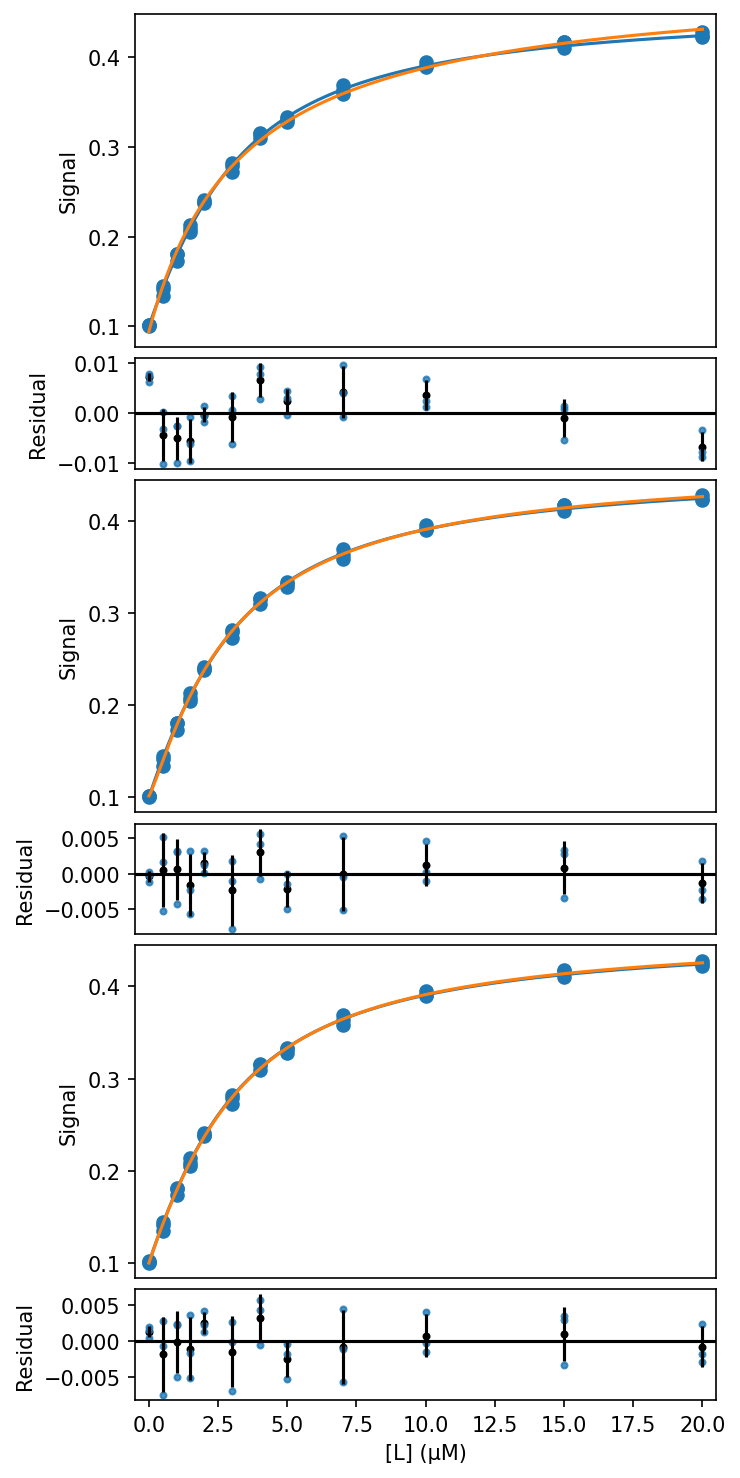

In [203]:
## Use curve_fit to estimate the model parameters

def sigmoid_scaled( x, *params, ):
    m, b = params[ : 2 ]
    shape_params = params[ 2 : ]
    return m * sigmoid_fit( x, *shape_params ) + b

def hill_scaled( x, *params, ):
    m, b = params[ : 2 ]
    shape_params = params[ 2 : ]
    return m * hill_fit( x, *shape_params ) + b
    
def quadratic_scaled( x, *params, ):
    m, b = params[ : 2 ]
    shape_params = params[ 2 : ]
    return m * quadratic_fit( x, *shape_params ) + b

sigmoid_fitted, sigmoid_var = curve_fit( sigmoid_scaled, bi_df.Conc, bi_df.Signal, init_param_nonhill, )
bi_df[ 'sigmoid_fitted' ] = sigmoid_scaled( bi_df.Conc, *sigmoid_fitted )
bi_df[ 'sigmoid_residual' ] = bi_df.Signal - bi_df.sigmoid_fitted
hill_fitted, hill_var = curve_fit( hill_scaled, bi_df.Conc, bi_df.Signal, init_param_hill, )
bi_df[ 'hill_fitted' ] = hill_scaled( bi_df.Conc, *hill_fitted )
bi_df[ 'hill_residual' ] = bi_df.Signal - bi_df.hill_fitted
bi_df[ 'receptor' ] = receptor_conc
quadratic_fitted, quadratic_var = curve_fit( quadratic_scaled, [bi_df.Conc, bi_df.receptor,], bi_df.Signal, init_param_nonhill, )
bi_df[ 'quadratic_fitted' ] = quadratic_scaled( [bi_df.Conc, receptor_conc], *quadratic_fitted )
bi_df[ 'quadratic_residual' ] = bi_df.Signal - bi_df.quadratic_fitted

# Get summary statistics per concentration
grouped = bi_df.groupby( 'Conc' )
mean_df = grouped.mean().reset_index()
std_df = grouped.std().reset_index()

fig, ax = plt.subplots( figsize=(5,12), dpi=150, nrows=6, gridspec_kw={'height_ratios':[3,1]*3} )

# Plot the expected lines
xt = np.linspace( 0, 20, 1000 )
yt = delta_signal * quadratic_fit( [xt, receptor_conc,], K_d, ) + free_signal
for i in range(3):
    ax[2*i].scatter( bi_df.Conc, bi_df.Signal )
    ax[2*i].plot( xt, yt, )
    ax[2*i].set_ylabel( 'Signal' )
    ax[2*i+1].plot( [-1,21], [0]*2, linestyle='-', color='black', )
    ax[2*i+1].set_xlabel( '[L] (μM)' )
    ax[2*i+1].set_ylabel( 'Residual' )
    




print( 'HIGHER IS BETTER' )



sigmoid_std = np.std( bi_df.Signal - bi_df.sigmoid_fitted, ddof=1, )
sigmoid_lnL = stats.norm.logpdf( x = bi_df.Signal, loc = bi_df.sigmoid_fitted, scale = sigmoid_std, )
sigmoid_sum_lnL = np.sum( sigmoid_lnL )
print( 'Sigmoid lnL =\t' + format( sigmoid_sum_lnL, '.4f', ) )

sigmoid_yt = sigmoid_scaled( xt, *sigmoid_fitted, )
ax[0].plot( xt, sigmoid_yt, )
ax[1].scatter( mean_df.Conc, mean_df.sigmoid_residual, s=8, c='black', )
ax[1].errorbar( mean_df.Conc, mean_df.sigmoid_residual, yerr=std_df.sigmoid_residual, color='black', ecolor='black', fmt='none', )
ax[1].scatter( bi_df.Conc, bi_df.sigmoid_residual, s=8, alpha=0.8, )



hill_std = np.std( bi_df.Signal - bi_df.hill_fitted, ddof=1, )
hill_lnL = stats.norm.logpdf( x = bi_df.Signal, loc = bi_df.hill_fitted, scale = hill_std, )
hill_sum_lnL = np.sum( hill_lnL )
print( 'Hill lnL =\t' + format( hill_sum_lnL, '.4f', ) )

yt = hill_scaled( xt, *hill_fitted, )
ax[2].plot( xt, yt, )
ax[3].scatter( mean_df.Conc, mean_df.hill_residual, s=8, c='black', )
ax[3].errorbar( mean_df.Conc, mean_df.hill_residual, yerr=std_df.hill_residual, color='black', ecolor='black', fmt='none', )
ax[3].scatter( bi_df.Conc, bi_df.hill_residual, s=8, alpha=0.8, )




quadratic_std = np.std( bi_df.Signal - bi_df.quadratic_fitted, ddof=1, )
quadratic_lnL = stats.norm.logpdf( x = bi_df.Signal, loc = bi_df.quadratic_fitted, scale = quadratic_std, )
quadratic_sum_lnL = np.sum( quadratic_lnL )
print( 'Quadratic lnL = ' + format( quadratic_sum_lnL, '.4f', ) )

yt = quadratic_scaled( (xt,receptor_conc), *quadratic_fitted, )
ax[4].plot( xt, yt, )
ax[5].scatter( mean_df.Conc, mean_df.quadratic_residual, s=8, c='black', )
ax[5].errorbar( mean_df.Conc, mean_df.quadratic_residual, yerr=std_df.quadratic_residual, color='black', ecolor='black', fmt='none', )
ax[5].scatter( bi_df.Conc, bi_df.quadratic_residual, s=8, alpha=0.8, )

for i in range(6):
    ax[i].set_xticks( [] )
    ax[i].set( xlim=(-0.5,20.5,), )
    
xticks = np.arange( 0, 22.5, 2.5, )
ax[-1].set_xticks( xticks )
ax[-1].set_xticklabels( [ format( x, '.1f' ) for x in xticks ],  )

fig.subplots_adjust( hspace=0.05 )


In [173]:
## Compute the AIC for each method

print( 'LOWER IS BETTER' )
sigmoid_aic = -2 * ( sigmoid_sum_lnL - len(init_param_nonhill) )
print( 'Sigmoid AIC =\t' + format( sigmoid_aic, '.4f', ) )

hill_aic = -2 * ( hill_sum_lnL - len(init_param_hill) )
print( 'Hill AIC =\t' + format( hill_aic, '.4f', ) )

quadratic_aic = -2 * ( quadratic_sum_lnL - len(init_param_nonhill) )
print( 'Quadratic AIC =\t' + format( quadratic_aic, '.4f', ) )

LOWER IS BETTER
Sigmoid AIC =	-184.5417
Hill AIC =	-225.3487
Quadratic AIC =	-226.7059


## Exponential lifetime decay signals

### Examples: Fluorescence lifetime, NMR relaxation

Let's actually make a small game out of our lnL/AIC estimations. Let's imagine we have an exponential decay process, but there may exist multiple unique states that decay at independent rates. Given the bulk measurement of the signal, can we infer how many signals exist in the underlying data?



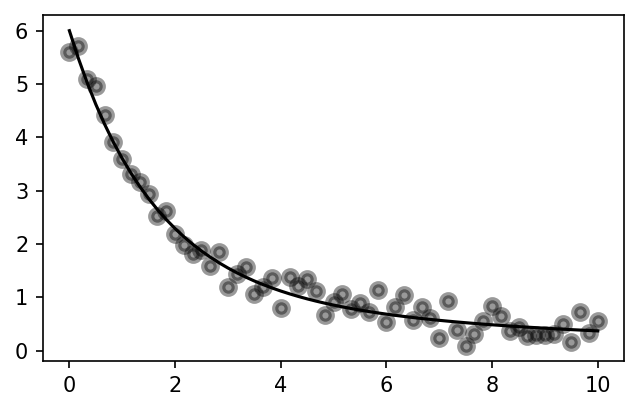

In [362]:
## Let's define some rules for the game

# There will exist between 2-6 signals
# The decay rates will be uniformally guessed with the min rate being no less than 10% of the max rate
# For this test, let's center m = 1 and b = 0 for simplicity -- but still estimate them as part of the process to properly control the # of degrees of freedom
# We will evaluate all scenarios between 1 to 10 signals

seed = 2994 # Set a random seed, which we don't know how many curves will get produced
min_n = 2
max_n = 8
random_float = stats.uniform( loc=min_n, scale=max_n-min_n+0.5, ).rvs( 1, random_state=seed, )
n_states = int( np.round( random_float ) )
rates = stats.uniform( loc=0.1, scale=0.9, ).rvs( n_states, random_state=seed, )
sigma = 2e-1


def n_exp_decay( x, *decay_rates, ):
    return np.sum( [ np.exp( -x*r ) for r in decay_rates ], axis=0, )

def scaled_decay( x, *params, ):
    m, b = params[:2]
    shape_params = params[2:]
    return m * n_exp_decay( x, *shape_params, ) + b


xt = np.linspace( 0, 10, 61, )
yt = n_exp_decay( xt, *rates ) + stats.norm.rvs( loc=0, scale=sigma, size=len(xt), random_state=seed, )

fig, ax = plt.subplots( figsize=(5,3), dpi=150, )

ax.plot( xt, n_exp_decay( xt, *rates ), color='black', zorder=1,)
ax.scatter( xt, yt, c='black', linewidth=3, alpha=0.4, zorder=2,)


N         sum_lnL        AIC
1         6.468          -10.935
2         7.780          -11.560
3         8.178          -10.355
4         8.533          -9.066
5         8.384          -6.768
6         8.579          -5.158
7         8.563          -3.125
8         8.533          -1.066
9         8.472          1.056
10        8.569          2.862
11        8.555          4.890
12        8.533          6.934
13        8.496          9.007
14        8.563          10.875
15        8.550          12.899
16        8.533          14.934
17        8.507          16.986


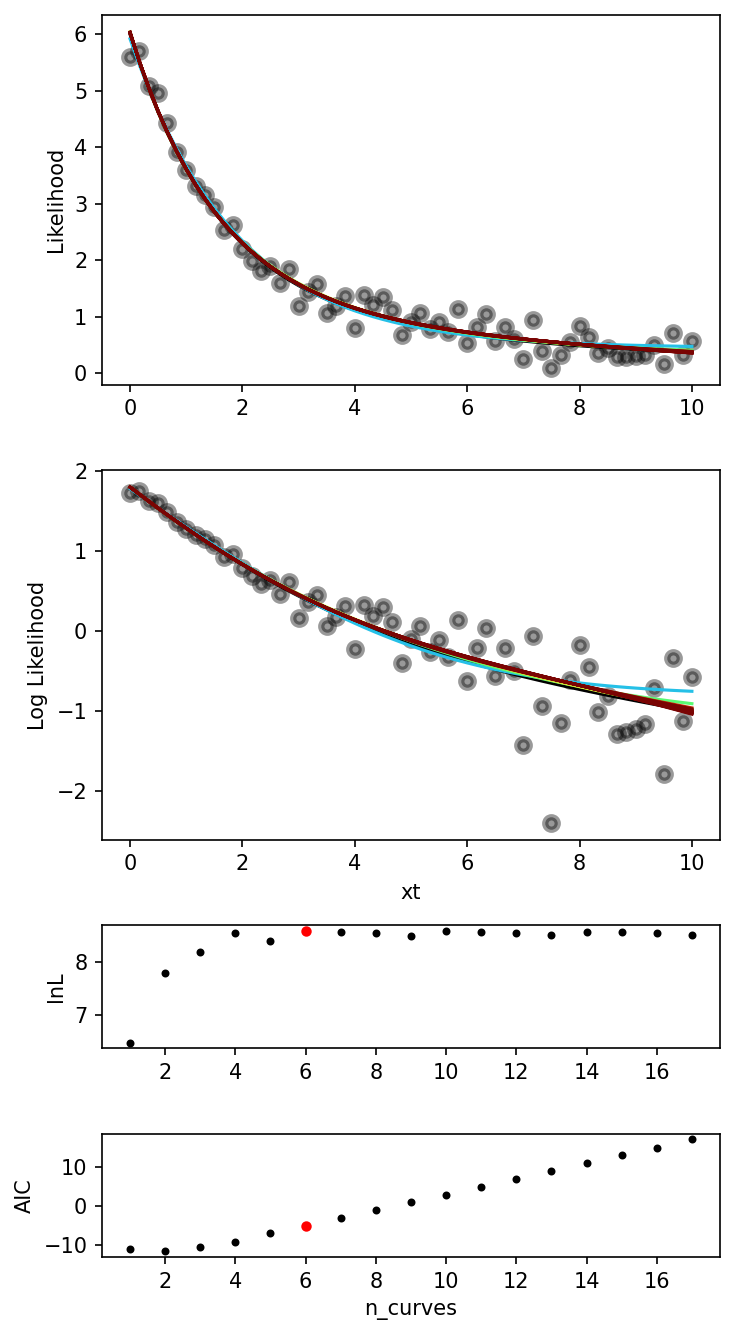

In [379]:
## Evaluate different possible states

fig, ax = plt.subplots( figsize=(5,9), dpi=150, nrows=4, gridspec_kw={'height_ratios':(3,3,1,1), })
ax[0].plot( xt, n_exp_decay( xt, *rates ), color='black', zorder=1,)
ax[0].scatter( xt, yt, c='black', linewidth=3, alpha=0.4, zorder=2,)
ax[1].plot( xt, np.log( n_exp_decay( xt, *rates ) ), color='black', zorder=1,)
ax[1].scatter( xt, np.log( yt ), c='black', linewidth=3, alpha=0.4, zorder=2,)


print( 'N'.ljust(10) + 'sum_lnL'.ljust(15) + 'AIC' )
eval_n = np.arange( 1, max_n+10, )
best_lnL = -1e6
for en in eval_n:
    #try:
    color = cm.turbo( 0.8*en/5 + 0.1 )
    init_rates = np.linspace( 1, en, en, ) / (en+1) # Uniformally spaced guesses
    init_params = np.array( [ 0.0, 1.0, ] + list( init_rates ) )
    fit, var = curve_fit( scaled_decay, xt, yt, init_params, maxfev=int(1e6), )
    fit_y = scaled_decay( xt, *fit, )
    ax[0].plot( xt, fit_y, color=color, zorder=3+en, )
    ax[1].plot( xt, np.log(fit_y), color=color, zorder=3+en, )

    residuals = yt - fit_y
    stdev = np.std( residuals, ddof=1, )
    lnL = stats.norm.logpdf( residuals, loc=0, scale=stdev, )
    sum_lnL = np.sum( lnL )
    if sum_lnL > best_lnL:
        best_params = np.array( fit )
    aic = -2 * ( sum_lnL - en )
    print( str(en).ljust(10) + format( sum_lnL, '.3f', ).ljust(15) + format( aic, '.3f' ) )
    ax[2].scatter( en, sum_lnL, 
                   color='black' if en != n_states else 'red', 
                   s=8 if en != n_states else 16, )
    ax[3].scatter( en, aic, 
                   color='black' if en != n_states else 'red', 
                   s=8 if en != n_states else 16, )
    #except:
    #    print( str(en) + ' OPTIMIZATION FAILED :(' )
    #    break

ax[1].set_xlabel( 'xt' )
ax[3].set_xlabel( 'n_curves')

ax[0].set_ylabel( 'Likelihood' )
ax[1].set_ylabel( 'Log Likelihood' )
ax[2].set_ylabel( 'lnL' )
ax[3].set_ylabel( 'AIC' )

fig.tight_layout()
